# TalentBait ML Challenge

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import json
import re
import warnings
import pickle

# Preprocessing tools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Evaluation metrics & Helpers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
# Open data with JSON Module

file = open('raw_data/tech_soft_none.json', encoding='utf-8')
data = json.load(file) 

df = pd.json_normalize(data['data'])

df.label = df.label.astype('category')

print('Shape df:', df.shape)
print('Unique labels:', df.label.unique())
df.head()

Shape df: (10249, 2)
Unique labels: ['none', 'tech', 'soft']
Categories (3, object): ['none', 'tech', 'soft']


,text,label
0,"Standort Trovarit AG München, Deutschland",none
1,Wir freuen uns auf Ihre Bewerbung unter Angabe...,none
2,Qualifikation zur Heimleitung gemäß Heimperson...,tech
3,Gute organisatorische und konzeptionelle Fähig...,soft
4,"Teamfähigkeit, hohe Flexibilität und Einsatzbe...",soft


In [3]:
# Missing values --> No missing values

df.isnull().sum()

text     0
label    0
dtype: int64

In [4]:
# Info df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   text    10249 non-null  object  
 1   label   10249 non-null  category
dtypes: category(1), object(1)
memory usage: 50.2+ KB


# Data Wrangling, Preprocessing & Feature Engineering 

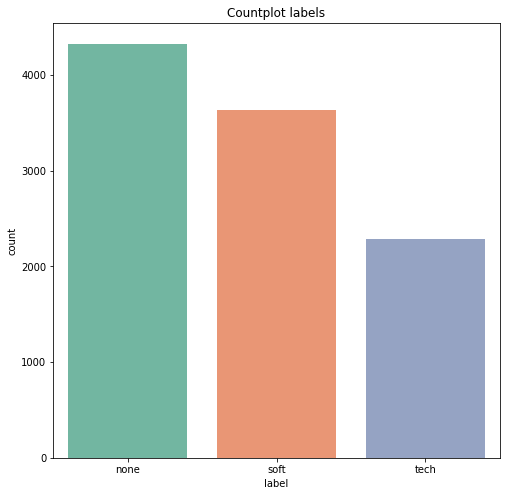

In [5]:
# Labels distribution

plt.figure(figsize=(8,8))
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Countplot labels')
plt.show()

Vermutung: Es sind verschiedene Links, Emails, Telefonnummer, PLZ Gebiete in den Textwerten drin, die für die tatsächliche Zuordnung bzw. Klassifikation erstmal keine Rolle spielen 

• Vermutung über die möglichen Telefonnummerformatierungen im Dataset
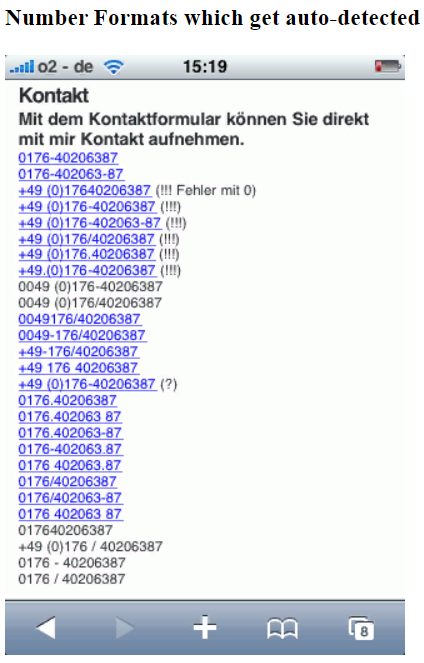

In [6]:
# Functions to remove HTML Tags, Handy numbers (minimal length 10 digits) & Links

def remove_urls(text):
    return re.sub(r'(http|https|www)\S+', '', text)

def remove_phone_numbers(text):
    
    """ Only digit sequences with min. length of 10 will be removed. 
    Important to avoid accidental address removal"""
    
    return re.sub(r'(\(?([\d \-\)\–\+\/\(]+){10,}\)?([ .\-–\/]?)([\d]+))', '', text)

def remove_emails(text):
    return re.sub(r'[\w\.-]+@[\w\.-]+', '', text)

def remove_characters(text):
    return re.sub(r'[^a-zA-Z0-9 \n\.]', '', text)

def to_lower(text):
    return text.lower()

def replace_umlaute(text):
    return text.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe').replace('ß', 'ss')


def text_cleaning(text):
    
    text = remove_urls(text)
    text = remove_phone_numbers(text)
    text = remove_emails(text)
    text = to_lower(text)
    text = replace_umlaute(text)
    text = remove_characters(text)
    
    return text

# Text Normalization incl. Tokenization, Lemmatization etc.

In [7]:
stop_words = set(stopwords.words('german'))

def to_word_tokens(text):
    return word_tokenize(text)    

def remove_stopwords(text):
    pure_text = []
    for i in text:
        if i.lower().strip() not in stop_words and i.strip().lower().isalpha():
            pure_text.append(i.lower())
    return " ".join(pure_text)

def text_normalization(text):
    
    text = to_word_tokens(text)
    text = remove_stopwords(text)
    
    return text


In [8]:
# General cleaning
# Text iloc to test --> 1, 87, 11, 98, -9

testnumber = 1

print('Before:', df.text.iloc[testnumber], '\n')
df.text = df.text.apply(text_cleaning)
df.text = df.text.apply(text_normalization)
print('After:', df.text.iloc[testnumber])

Before: Wir freuen uns auf Ihre Bewerbung unter Angabe Ihrer Gehaltsvorstellung und Ihres möglichen Eintrittstermins. Der ALTE LEIPZIGER – HALLESCHE Konzern begrüßt ausdrücklich die Bewerbung von Menschen mit Behinderung. Bei Fragen und für weitere Informationen wenden Sie sich gerne an Elke Lang unter 0711-6603-2411 . Ihre ausführlichen Bewerbungsunterlagen senden Sie bitte an bewerbung@hallesche.de oder per Post an: HALLESCHE Krankenversicherung a. G. Personal und Soziales Reinsburgstraße 10 70178 Stuttgart www.hallesche.de 

After: freuen bewerbung angabe gehaltsvorstellung moeglichen eintrittstermins alte leipziger hallesche konzern begruesst ausdruecklich bewerbung menschen behinderung fragen fuer weitere informationen wenden gerne elke lang ausfuehrlichen bewerbungsunterlagen senden bitte per post hallesche krankenversicherung personal soziales reinsburgstrasse stuttgart


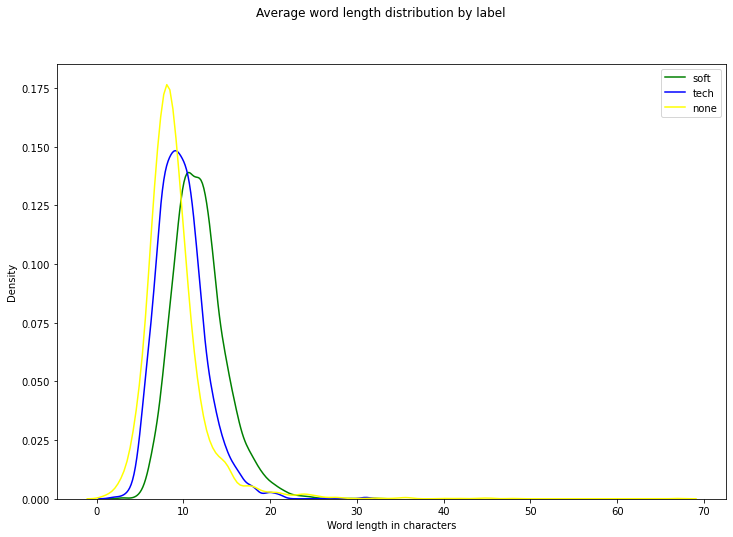

In [9]:
# Plotting average word length distribution by label

soft = df[df['label'] == 'soft']
tech = df[df['label'] == 'tech']
none = df[df['label'] == 'none']


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle('Average word length distribution by label')

    soft_length = soft['text'].str.split().map(lambda x: [len(i) for i in x])
    sns.kdeplot(soft_length.map(lambda x: np.mean(x)), ax=ax, color='green', label='soft')

    tech_length = tech['text'].str.split().map(lambda x: [len(i) for i in x])
    sns.kdeplot(tech_length.map(lambda x: np.mean(x)), ax=ax, color='blue', label='tech')

    none_length = none['text'].str.split().map(lambda x: [len(i) for i in x])
    sns.kdeplot(none_length.map(lambda x: np.mean(x)), ax=ax, color='yellow', label='none')
    ax.set_xlabel('Word length in characters')
    ax.set_ylabel('Density')

    plt.legend()
    plt.show()

In [10]:
# # Encoding label features to numeric
# • 0 --> none
# • 1 --> soft
# • 2 --> tech

le = LabelEncoder()

df.label = le.fit_transform(df.label)
df.head()

,text,label
0,standort trovarit ag muenchen deutschland,0
1,freuen bewerbung angabe gehaltsvorstellung moe...,0
2,qualifikation heimleitung gemaess heimpersonal...,2
3,gute organisatorische konzeptionelle faehigkeiten,1
4,teamfaehigkeit hohe flexibilitaet einsatzberei...,1


# Metrics Prep & Splitting Dataset

In [11]:
# Custom function for metrics evaluation

def metrics_eval(y_test=None, y_pred=None, model=None):
    
    """ Custom function for model evaluation to make code more reusable """
    
    print('--------------------{m} Model--------------------'.format(m=model), '\n')
    
    print('--------------Confusion Matrix--------------', '\n', confusion_matrix(y_test, y_pred), '\n')
    
    print('--------------Classification Report--------------', '\n', classification_report(y_test, y_pred), '\n')
    
    print('--------------Total accuracy--------------', '\n', accuracy_score(y_test, y_pred), '\n')
    

In [46]:
# TfIdf Vectorization 1

x_data = df.text
y_data = df.label

tfidf = TfidfVectorizer(max_features=1800, min_df=2, max_df=35, decode_error='strict')
X = tfidf.fit_transform(x_data).toarray()
print('Shape X:', X.shape)
print('Shape Y:', y_data.shape)

with open('models/tfidf_vectorizer', 'wb') as tfidf_vectorizer:
    pickle.dump(tfidf, tfidf_vectorizer)

Shape X: (10249, 1800)
Shape Y: (10249,)


In [23]:
# Split data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.25, random_state=42)
print('Shape X_train:', X_train.shape)
print('Shape y_train:', y_train.shape)

Shape X_train: (7686, 1800)
Shape y_train: (7686,)


# NaiveBayes (MultinominalNB) & Evaluation

In [24]:
# Simple MNB as Classifier

mnb = MultinomialNB(alpha=0.8)

mnb.fit(X_train, y_train)

y_pred_mnb = mnb.predict(X=X_test)

In [25]:
# Evaluating the MNB

metrics_eval(y_pred=y_pred_mnb, y_test=y_test, model='Naive Bayes')

--------------------None Model-------------------- 

--------------Confusion Matrix-------------- 
 [[990  37  25]
 [326 592  18]
 [178  54 343]] 

--------------Classification Report-------------- 
               precision    recall  f1-score   support

           0       0.66      0.94      0.78      1052
           1       0.87      0.63      0.73       936
           2       0.89      0.60      0.71       575

    accuracy                           0.75      2563
   macro avg       0.81      0.72      0.74      2563
weighted avg       0.79      0.75      0.75      2563
 

--------------Total accuracy-------------- 
 0.7510729613733905 



In [29]:
# Save MNB

with open('models/mnb_classifier', 'wb') as picklefile:
    pickle.dump(mnb, picklefile)

# RandomForestClassifier & Evaluation

In [48]:
# TfIdf Vectorization 2

tfidf2 = TfidfVectorizer(max_features=1800, min_df=3, max_df=25, decode_error='strict')
X = tfidf2.fit_transform(x_data).toarray()
print('Shape X:', X.shape)
print('Shape Y:', y_data.shape)

with open('models/tfidf_vectorizer2', 'wb') as tfidf_vectorizer:
    pickle.dump(tfidf2, tfidf_vectorizer)

Shape X: (10249, 1800)
Shape Y: (10249,)


In [49]:
# Simple RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(X=X_train, y=y_train)

y_pred = rfc.predict(X_test)

In [50]:
# RandomizedSearchGrid basic parameters tuning

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2200, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
max_features = ['auto', 'sqrt']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid


{'n_estimators': [200, 422, 644, 866, 1088, 1311, 1533, 1755, 1977, 2200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [51]:
# Initiating RandomizedSCV

# rf_rand = RandomizedSearchCV(estimator = rfc, 
#                              param_distributions = random_grid, 
#                              n_iter = 2, 
#                              cv = 3, 
#                              verbose=2, 
#                              random_state=42, 
#                              n_jobs = -1)

# rf_rand.fit(X_train, y_train)
# rf_rand.best_params_

In [52]:
# Model evaluation

metrics_eval(y_test=y_test, y_pred=y_pred, model='RandomForest')

--------------------RandomForest Model-------------------- 

--------------Confusion Matrix-------------- 
 [[980  45  27]
 [328 576  32]
 [189  42 344]] 

--------------Classification Report-------------- 
               precision    recall  f1-score   support

           0       0.65      0.93      0.77      1052
           1       0.87      0.62      0.72       936
           2       0.85      0.60      0.70       575

    accuracy                           0.74      2563
   macro avg       0.79      0.72      0.73      2563
weighted avg       0.78      0.74      0.74      2563
 

--------------Total accuracy-------------- 
 0.74131876706984 



In [53]:
# Save RFC

with open('models/rfc_classifier', 'wb') as picklefile:
    pickle.dump(rfc, picklefile)

# KNeighborsClassifier & Evaluation

In [62]:
# K-Nearest-Neighbors as Classifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X=X_train, y=y_train)

y_pred_knn = knn.predict(X=X_test)

In [63]:
# Model evaluation

metrics_eval(y_test=y_test, y_pred=y_pred_knn, model='KNN', labels=abilities)

--------------------KNN Model-------------------- 

--------------Confusion Matrix-------------- 
 [[669 360  23]
 [ 91 831  14]
 [102 225 248]] 

--------------Classification Report-------------- 
               precision    recall  f1-score   support

           0       0.78      0.64      0.70      1052
           1       0.59      0.89      0.71       936
           2       0.87      0.43      0.58       575

    accuracy                           0.68      2563
   macro avg       0.74      0.65      0.66      2563
weighted avg       0.73      0.68      0.67      2563
 

--------------Total accuracy-------------- 
 0.6820132657042528 



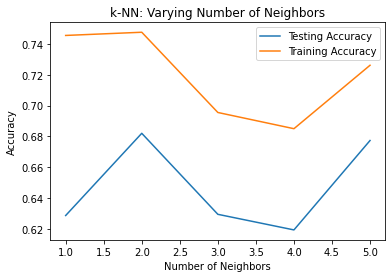

In [37]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 5)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    
    knn = KNeighborsClassifier(n_neighbors=k)

    # Training data
    knn.fit(X_train, y_train)
    
    # Training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [38]:
# Save KNN

with open('models/knn_classifier', 'wb') as picklefile:
    pickle.dump(knn, picklefile)

# KNeighborsClassifier + Cross Validation & Evaluation

In [39]:
# Training the model with 5 folds --> model will be trained on 5 different groups from the origin dataset

knn_cv = KNeighborsClassifier(n_neighbors=4)
cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5) # Optional: X, y_data
print('Cross Validation scores:', cv_scores)
print('Mean of the CV scores:', np.mean(cv_scores))

Cross Validation scores: [0.63979194 0.65907612 0.67143787 0.69160703 0.67664281]
Mean of the CV scores: 0.6677111526431254


In [40]:
knn_cv.fit(X=X_train, y=y_train)
y_pred_knn_cv = knn_cv.predict(X_test)

In [41]:
# Model evaluation

metrics_eval(y_test=y_test, y_pred=y_pred_knn_cv, model='KNN_CV')

--------------------KNN_CV Model-------------------- 

--------------Confusion Matrix-------------- 
 [[620  85 347]
 [ 70 557 309]
 [ 75  90 410]] 

--------------Classification Report-------------- 
               precision    recall  f1-score   support

           0       0.81      0.59      0.68      1052
           1       0.76      0.60      0.67       936
           2       0.38      0.71      0.50       575

    accuracy                           0.62      2563
   macro avg       0.65      0.63      0.62      2563
weighted avg       0.70      0.62      0.64      2563
 

--------------Total accuracy-------------- 
 0.6191962543893874 



In [42]:
# Choosing optimal number of neighbors with GridSearchCV (5 folds)

# knn_gs = KNeighborsClassifier()

# grid_parameters = {'n_neighbors': np.arange(1, 5)}
# knn_gs = GridSearchCV(knn_gs, grid_parameters, cv=5)
# knn_gs.fit(X=X, y=y_data)
# print('Best amount of neighbors:', knn_gs.best_params_)

In [43]:
# Save KNN_CV

with open('models/knn_cv_classifier', 'wb') as picklefile:
    pickle.dump(knn_cv, picklefile)

# Testing models on custom list

In [44]:
custom_list = ['Profunde Praxiskenntnisse in Virtualisierungslösungen (VMware)', 
              'Eigeninitiative, gute Motivation und hohe Zielorientierung +49 1520 24512482 anrufen!!!!!!', 
              'Gute Sprachkenntnisse auf deutsch in Wort und Schrift.',
              'Personalentwicklung (m/w/-*/) Extra: Apfel & Birne Verkauf']

def data_feeding(query):
       
    query = list(map(text_cleaning, query))
    query = list(map(text_normalization, query))
    query = tfidf.transform(query)
        
    return query.toarray()

Xc_test = data_feeding(custom_list)

In [45]:
# Label classification test on list
                
y_pred_final = knn.predict(Xc_test)
print(y_pred_final)

output_df = pd.DataFrame(data = {'text': custom_list, 'code': y_pred_final})
print(output_df)

[2 1 1 1]
                                                text  code
0  Profunde Praxiskenntnisse in Virtualisierungsl...     2
1  Eigeninitiative, gute Motivation und hohe Ziel...     1
2  Gute Sprachkenntnisse auf deutsch in Wort und ...     1
3  Personalentwicklung (m/w/-*/) Extra: Apfel & B...     1


# Interpretation & Vorschläge


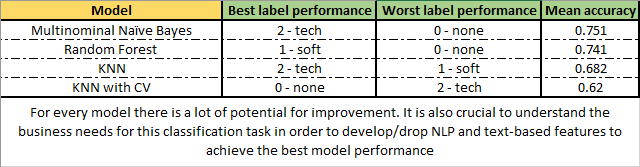

• For interpretations and some improvements suggestions go to: verbesserungsvorschlaege.txt